Training period: giorni 1-1913
Evaluation period: giorni 1914-1941
Forecast horizon: 28 giorni

[1/3] Caricamento dataset...
✓ Sales shape: (30490, 1947)
✓ Calendar shape: (1969, 14)
✓ Prices shape: (6841121, 4)

[2/3] Analisi struttura gerarchica...

Gerarchia (12 livelli):
--------------------------------------------------------------------------------
Level 1 - Total                               1 serie
Level 2 - State                               3 serie
Level 3 - Store                              10 serie
Level 4 - Category                            3 serie
Level 5 - Department                          7 serie
Level 6 - State+Category                      9 serie
Level 7 - State+Department                   21 serie
Level 8 - Store+Category                     30 serie
Level 9 - Store+Department                   70 serie
Level 10 - Product                        3,049 serie
Level 11 - Product+State                  9,147 serie
Level 12 - Product+Store (Bottom)        30,490 s

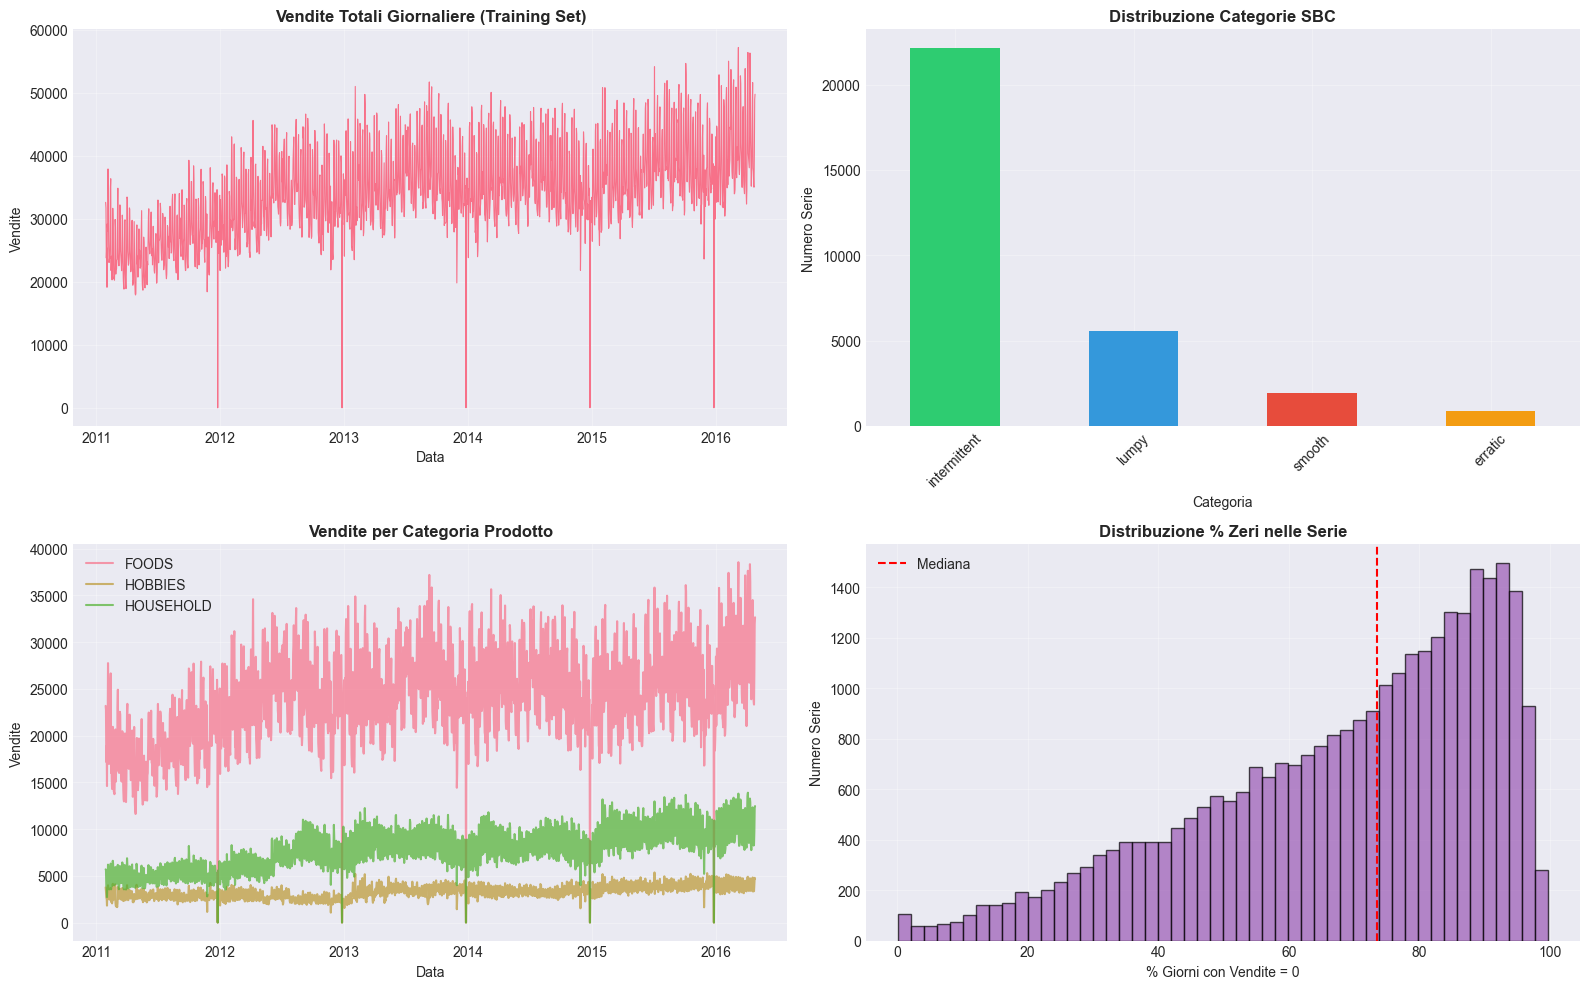

In [1]:
# ============================================================================
# Data Preparation & EDA
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Configurazione plot
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. SETUP E CONFIGURAZIONE
# ============================================================================

# Path ai dati
DATA_DIR = Path("../data/raw")
OUTPUT_DIR = Path("../data/processed")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_END_DAY = 1913  # Dal 2011-01-29 al 2016-04-24
EVAL_START_DAY = 1914  # Dal 2016-04-25 al 2016-05-22
EVAL_END_DAY = 1941
FORECAST_HORIZON = 28

print(f"Training period: giorni 1-{TRAIN_END_DAY}")
print(f"Evaluation period: giorni {EVAL_START_DAY}-{EVAL_END_DAY}")
print(f"Forecast horizon: {FORECAST_HORIZON} giorni")

# ============================================================================
# 2. CARICAMENTO DATI
# ============================================================================

print("\n[1/3] Caricamento dataset...")

# Sales data
sales = pd.read_csv(DATA_DIR / "sales_train_evaluation.csv")
print(f"✓ Sales shape: {sales.shape}")

# Calendar
calendar = pd.read_csv(DATA_DIR / "calendar.csv")
print(f"✓ Calendar shape: {calendar.shape}")

# Prices
prices = pd.read_csv(DATA_DIR / "sell_prices.csv")
print(f"✓ Prices shape: {prices.shape}")

# ============================================================================
# 3. ANALISI STRUTTURA GERARCHICA
# ============================================================================

print("\n[2/3] Analisi struttura gerarchica...")

# Estrazione componenti gerarchiche
sales['state_id'] = sales['store_id'].str[:2]
sales['cat_id'] = sales['item_id'].str.split('_').str[0]

# Conteggio per livello
hierarchy_stats = {
    'Level 1 - Total': 1,
    'Level 2 - State': sales['state_id'].nunique(),
    'Level 3 - Store': sales['store_id'].nunique(),
    'Level 4 - Category': sales['cat_id'].nunique(),
    'Level 5 - Department': sales['dept_id'].nunique(),
    'Level 6 - State+Category': sales.groupby(['state_id', 'cat_id']).ngroups,
    'Level 7 - State+Department': sales.groupby(['state_id', 'dept_id']).ngroups,
    'Level 8 - Store+Category': sales.groupby(['store_id', 'cat_id']).ngroups,
    'Level 9 - Store+Department': sales.groupby(['store_id', 'dept_id']).ngroups,
    'Level 10 - Product': sales['item_id'].nunique(),
    'Level 11 - Product+State': sales.groupby(['item_id', 'state_id']).ngroups,
    'Level 12 - Product+Store (Bottom)': len(sales),
}

print("\nGerarchia (12 livelli):")
print("-"*80)
for level, count in hierarchy_stats.items():
    print(f"{level:<40} {count:>6,} serie")
print("-"*80)
print(f"{'TOTALE SERIE TEMPORALI':<40} {sum(hierarchy_stats.values()):>6,}")
print("="*80)

# Salva mapping gerarchico
hierarchy_mapping = {
    'id': sales['id'].values,
    'item_id': sales['item_id'].values,
    'dept_id': sales['dept_id'].values,
    'cat_id': sales['cat_id'].values,
    'store_id': sales['store_id'].values,
    'state_id': sales['state_id'].values,
}

with open(OUTPUT_DIR / "hierarchy_mapping.pkl", 'wb') as f:
    pickle.dump(hierarchy_mapping, f)
print("✓ Salvato: hierarchy_mapping.pkl")

# ============================================================================
# 4. RESHAPE DATI IN FORMATO LONG
# ============================================================================

print("\n[3/3] Reshape e split ufficiale...")

# Colonne di vendita (d_1 a d_1941)
sales_cols = [col for col in sales.columns if col.startswith('d_')]
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# Reshape da wide a long
sales_long = sales.melt(
    id_vars=id_cols,
    value_vars=sales_cols,
    var_name='d',
    value_name='sales'
)

print(f"✓ Sales long format shape: {sales_long.shape}")

# Merge con calendar per avere date
sales_long = sales_long.merge(calendar[['d', 'date', 'wm_yr_wk']], on='d', how='left')
sales_long['date'] = pd.to_datetime(sales_long['date'])

# Ordina per id e data
sales_long = sales_long.sort_values(['id', 'date']).reset_index(drop=True)

# ============================================================================
# 5. SPLIT UFFICIALE TRAIN/EVAL
# ============================================================================

# Estrai numero giorno da 'd_1', 'd_2', etc.
sales_long['day_num'] = sales_long['d'].str.replace('d_', '').astype(int)

# Split
train = sales_long[sales_long['day_num'] <= TRAIN_END_DAY].copy()
eval_data = sales_long[
    (sales_long['day_num'] >= EVAL_START_DAY) & 
    (sales_long['day_num'] <= EVAL_END_DAY)
].copy()

print(f"\n✓ Train set: {train.shape} (giorni 1-{TRAIN_END_DAY})")
print(f"✓ Eval set: {eval_data.shape} (giorni {EVAL_START_DAY}-{EVAL_END_DAY})")
print(f"  Date range train: {train['date'].min()} to {train['date'].max()}")
print(f"  Date range eval: {eval_data['date'].min()} to {eval_data['date'].max()}")

# ============================================================================
# 6. ANALISI INTERMITTENZA (SBC Classification)
# ============================================================================

print("\n[4/6] Analisi intermittenza serie temporali...")

def calculate_intermittency_metrics(series):
    """
    Calcola metriche di intermittenza secondo Syntetos-Boylan-Croston (SBC).
    
    """
    # Rimuovi valori nulli
    series = series[~series.isna()]
    
    # Statistiche base
    mean_demand = series[series > 0].mean() if (series > 0).sum() > 0 else 0
    std_demand = series[series > 0].std() if (series > 0).sum() > 1 else 0
    
    # CV² (Coefficient of Variation squared)
    cv2 = (std_demand / mean_demand) ** 2 if mean_demand > 0 else np.inf
    
    # ADI (Average inter-Demand Interval)
    non_zero_indices = np.where(series > 0)[0]
    if len(non_zero_indices) > 1:
        intervals = np.diff(non_zero_indices)
        adi = intervals.mean()
    else:
        adi = len(series)
    
    # Classificazione SBC
    if cv2 <= 0.49 and adi <= 1.32:
        category = 'smooth'
    elif cv2 <= 0.49 and adi > 1.32:
        category = 'intermittent'
    elif cv2 > 0.49 and adi < 1.32:
        category = 'erratic'
    else:  # cv2 > 0.49 and adi >= 1.32
        category = 'lumpy'
    
    return {
        'cv2': cv2,
        'adi': adi,
        'category': category,
        'zero_percentage': (series == 0).sum() / len(series) * 100,
        'mean_sales': series.mean(),
        'std_sales': series.std()
    }

# Calcola metriche per ogni serie (solo su training set)
train_pivot = train.pivot(index='date', columns='id', values='sales')
intermittency_stats = {}

for col in train_pivot.columns:
    intermittency_stats[col] = calculate_intermittency_metrics(train_pivot[col])

# Converti in DataFrame
intermittency_df = pd.DataFrame(intermittency_stats).T
intermittency_df.index.name = 'id'
intermittency_df = intermittency_df.reset_index()

# Statistiche per categoria
category_counts = intermittency_df['category'].value_counts()
print("\nDistribuzione categorie SBC:")
print("-"*80)
for cat, count in category_counts.items():
    pct = count / len(intermittency_df) * 100
    print(f"{cat.capitalize():<20} {count:>6,} serie ({pct:>5.1f}%)")
print("-"*80)

print(f"\nStatistiche intermittenza:")
print(f"  Zero percentage media: {intermittency_df['zero_percentage'].mean():.1f}%")
print(f"  Zero percentage mediana: {intermittency_df['zero_percentage'].median():.1f}%")
print(f"  ADI medio: {intermittency_df['adi'].mean():.2f}")
print(f"  CV² medio: {intermittency_df[intermittency_df['cv2'] != np.inf]['cv2'].mean():.2f}")

# Salva statistiche intermittenza
with open(OUTPUT_DIR / "intermittency_stats.pkl", 'wb') as f:
    pickle.dump(intermittency_df, f)
print("\n✓ Salvato: intermittency_stats.pkl")

# ============================================================================
# 7. CALCOLO PESI WRMSSE
# ============================================================================

print("\n[5/6] Calcolo pesi WRMSSE...")

# Merge sales con prices
train_with_prices = train.merge(
    prices[['store_id', 'item_id', 'wm_yr_wk', 'sell_price']], 
    on=['store_id', 'item_id', 'wm_yr_wk'], 
    how='left'
)

# Calcola revenue (vendite × prezzo)
train_with_prices['revenue'] = train_with_prices['sales'] * train_with_prices['sell_price']

# Gestisci missing prices (forward fill per store×item)
train_with_prices = train_with_prices.sort_values(['store_id', 'item_id', 'date'])
train_with_prices['sell_price'] = train_with_prices.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='ffill')
train_with_prices['sell_price'] = train_with_prices.groupby(['store_id', 'item_id'])['sell_price'].fillna(method='bfill')

# Ricalcola revenue dopo fill
train_with_prices['revenue'] = train_with_prices['sales'] * train_with_prices['sell_price'].fillna(0)

# Calcola revenue totale per serie (ultimi 28 giorni del training)
last_28_days = train_with_prices[train_with_prices['day_num'] > (TRAIN_END_DAY - 28)]
revenue_by_series = last_28_days.groupby('id')['revenue'].sum().reset_index()
revenue_by_series.columns = ['id', 'total_revenue']

# Calcola pesi (normalizzati)
total_revenue = revenue_by_series['total_revenue'].sum()
revenue_by_series['weight'] = revenue_by_series['total_revenue'] / total_revenue

print(f"✓ Revenue totale (ultimi 28 giorni): ${total_revenue:,.2f}")
print(f"  Serie con peso massimo: {revenue_by_series['weight'].max():.6f}")
print(f"  Serie con peso minimo: {revenue_by_series['weight'].min():.6f}")
print(f"  Peso medio: {revenue_by_series['weight'].mean():.6f}")

# Salva pesi
with open(OUTPUT_DIR / "wrmsse_weights.pkl", 'wb') as f:
    pickle.dump(revenue_by_series, f)
print("✓ Salvato: wrmsse_weights.pkl")

# ============================================================================
# 8. FEATURE ENGINEERING CALENDARIO
# ============================================================================

print("\n[6/6] Feature engineering calendario...")

# Date features
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day
calendar['dayofweek'] = calendar['date'].dt.dayofweek
calendar['is_weekend'] = calendar['dayofweek'].isin([5, 6]).astype(int)

# Event features
calendar['is_event'] = (~calendar['event_name_1'].isna()).astype(int)
calendar['is_sporting'] = (calendar['event_type_1'] == 'Sporting').astype(int)
calendar['is_cultural'] = (calendar['event_type_1'] == 'Cultural').astype(int)
calendar['is_national'] = (calendar['event_type_1'] == 'National').astype(int)
calendar['is_religious'] = (calendar['event_type_1'] == 'Religious').astype(int)

# SNAP features per stato
calendar['snap_CA'] = calendar['snap_CA'].astype(int)
calendar['snap_TX'] = calendar['snap_TX'].astype(int)
calendar['snap_WI'] = calendar['snap_WI'].astype(int)

# Salva calendar features
calendar_features = calendar[[
    'd', 'date', 'wm_yr_wk', 'year', 'month', 'day', 'dayofweek', 
    'is_weekend', 'is_event', 'is_sporting', 'is_cultural', 
    'is_national', 'is_religious', 'snap_CA', 'snap_TX', 'snap_WI'
]]

with open(OUTPUT_DIR / "calendar_features.pkl", 'wb') as f:
    pickle.dump(calendar_features, f)
print("✓ Salvato: calendar_features.pkl")

# ============================================================================
# 9. SALVATAGGIO DATASET FINALI
# ============================================================================

print("\n[7/7] Salvataggio dataset processati...")

# Ottimizza memory usage
def optimize_dtypes(df):
    """Ottimizza data types per ridurre memoria."""
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

train = optimize_dtypes(train)
eval_data = optimize_dtypes(eval_data)

# Salva train e eval
with open(OUTPUT_DIR / "train_official.pkl", 'wb') as f:
    pickle.dump(train, f)
print(f"✓ Salvato: train_official.pkl ({train.memory_usage(deep=True).sum() / 1024**2:.1f} MB)")

with open(OUTPUT_DIR / "eval_official.pkl", 'wb') as f:
    pickle.dump(eval_data, f)
print(f"✓ Salvato: eval_official.pkl ({eval_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB)")

# ============================================================================
# 10. VISUALIZZAZIONI
# ============================================================================

print("\n[8/8] Generazione visualizzazioni...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Vendite totali giornaliere
daily_sales = train.groupby('date')['sales'].sum()
axes[0, 0].plot(daily_sales.index, daily_sales.values, linewidth=0.8)
axes[0, 0].set_title('Vendite Totali Giornaliere (Training Set)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Vendite')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Distribuzione categorie intermittenza
category_counts.plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
axes[0, 1].set_title('Distribuzione Categorie SBC', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Categoria')
axes[0, 1].set_ylabel('Numero Serie')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Vendite per categoria prodotto
cat_sales = train.groupby(['date', 'cat_id'])['sales'].sum().reset_index()
for cat in cat_sales['cat_id'].unique():
    cat_data = cat_sales[cat_sales['cat_id'] == cat]
    axes[1, 0].plot(cat_data['date'], cat_data['sales'], label=cat, alpha=0.7)
axes[1, 0].set_title('Vendite per Categoria Prodotto', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Data')
axes[1, 0].set_ylabel('Vendite')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Distribuzione zero percentage
axes[1, 1].hist(intermittency_df['zero_percentage'], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribuzione % Zeri nelle Serie', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('% Giorni con Vendite = 0')
axes[1, 1].set_ylabel('Numero Serie')
axes[1, 1].axvline(intermittency_df['zero_percentage'].median(), color='red', linestyle='--', label='Mediana')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "01_eda_summary.png", dpi=150, bbox_inches='tight')
print("✓ Salvato: 01_eda_summary.png")